<a href="https://colab.research.google.com/github/sriharshitha12/python-project_1261/blob/main/netflix%20code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ✅ Step 1: Import libraries
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# ✅ Step 2: Load dataset
df = pd.read_csv("Netflix Dataset.csv")  # <-- replace with your uploaded CSV path

# ✅ Step 3: Basic preprocessing
df = df[df['Title'].notna()]

# Text features
df['text_blob'] = (df['Title'].fillna('') + ' ' +
                   df['Description'].fillna('') + ' ' +
                   df['Type'].fillna(''))

# Target variable (Movie / TV Show classification)
y = df['Category']  # Movie or TV Show

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_text = tfidf.fit_transform(df['text_blob'])

# Optional numeric features
def parse_duration(d):
    if pd.isna(d): return np.nan
    m = re.search(r'(\d+)', str(d))
    return int(m.group(1)) if m else np.nan

df['duration_min'] = df['Duration'].apply(parse_duration)
num_features = df[['duration_min']].fillna(0)
X_num = StandardScaler().fit_transform(num_features)

# Final feature matrix
from scipy.sparse import hstack
X = hstack([X_text, X_num])

# ✅ Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ✅ Step 5: Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    # "Naive Bayes": MultinomialNB(), # Removed due to negative values from StandardScaler
    "KNN": KNeighborsClassifier(),
    "SVM": SVC()
}

# ✅ Step 6: Train & evaluate
for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))


===== Logistic Regression =====
              precision    recall  f1-score   support

       Movie       1.00      1.00      1.00      1076
     TV Show       0.99      1.00      1.00       482

    accuracy                           1.00      1558
   macro avg       1.00      1.00      1.00      1558
weighted avg       1.00      1.00      1.00      1558


===== Decision Tree =====
              precision    recall  f1-score   support

       Movie       1.00      1.00      1.00      1076
     TV Show       1.00      1.00      1.00       482

    accuracy                           1.00      1558
   macro avg       1.00      1.00      1.00      1558
weighted avg       1.00      1.00      1.00      1558


===== Random Forest =====
              precision    recall  f1-score   support

       Movie       1.00      1.00      1.00      1076
     TV Show       1.00      1.00      1.00       482

    accuracy                           1.00      1558
   macro avg       1.00      1.00      1.

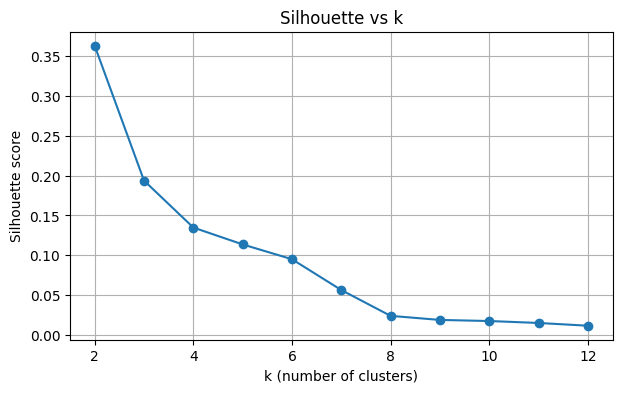

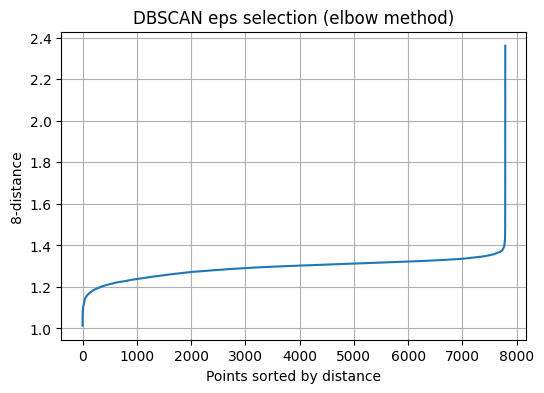

Cluster 0: tv, shows, international, crime, kids, series, docuseries, dramas, comedies, reality, romantic, british
  Sample titles: ['3%', '46', '1983']
Cluster 1: movies, comedies, international, dramas, independent, documentaries, family, adventure, children, thrillers, horror
  Sample titles: ['07:19', '23:59', '9']
Cluster 2: movies, dramas, international, action, adventure, comedies, music, musicals, man, love, young
  Sample titles: ['1920', 'Oct-01', '22-Jul']
Cluster 3: stand, comedy, documentaries, movies, family, special, children, comedian, documentary, comic, international, life
  Sample titles: ['#Rucker50', '100 Things to do Before High School', "100 Years: One Woman's Fight for Justice"]
Cluster 4: movies, dramas, international, comedies, action, adventure, romantic, independent, thrillers, man, young
  Sample titles: ['21', '187', '706']
Adjusted Rand Index: 0.39439977166352047
Normalized Mutual Info: 0.5452216516296137
✅ Saved clustered results to netflix_unsupervised_

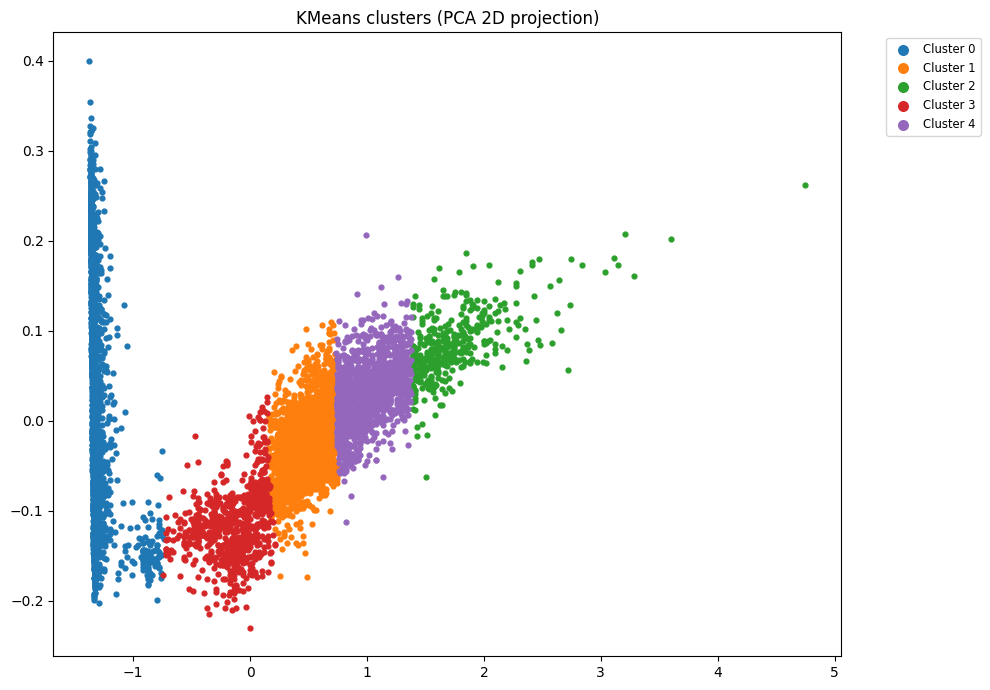

In [7]:
# === Step 6: Unsupervised Learning – Evaluation & Interpretation ===
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

# Initialize results dictionary
results = {}

# ----------------- 1) Silhouette vs k (KMeans quality curve) -----------------
ks = list(range(2, 13))
scores = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labs = km.fit_predict(X)
    try:
        sc = silhouette_score(X, labs)
    except Exception:
        sc = float("nan")
    scores.append(sc)

plt.figure(figsize=(7, 4))
plt.plot(ks, scores, "-o")
plt.xlabel("k (number of clusters)")
plt.ylabel("Silhouette score")
plt.title("Silhouette vs k")
plt.grid(True)
plt.show()

# ----------------- 2) DBSCAN tuning (k-distance plot) -----------------
k_nn = 8
nbrs = NearestNeighbors(n_neighbors=k_nn).fit(X)
distances, _ = nbrs.kneighbors(X)
distances = np.sort(distances[:, -1])
plt.figure(figsize=(6, 4))
plt.plot(distances)
plt.ylabel(f"{k_nn}-distance")
plt.xlabel("Points sorted by distance")
plt.title("DBSCAN eps selection (elbow method)")
plt.grid(True)
plt.show()

# Perform KMeans clustering and store results
km = KMeans(n_clusters=5, random_state=42, n_init=10)  # Using k=5 as example
results['kmeans'] = km.fit_predict(X)

# ----------------- 3) Top terms per cluster -----------------
def top_terms_per_cluster_sparse(tfidf_vectorizer, X_tfidf, labels, top_n=10):
    # ✅ Ensure CSR format so slicing works
    X_csr = X_tfidf.tocsr()
    terms = np.array(tfidf_vectorizer.get_feature_names_out())
    out = {}
    for lbl in sorted(set(labels)):
        if lbl == -1:
            out[lbl] = ["(noise)"]
            continue
        idx = np.where(labels == lbl)[0]
        if len(idx) == 0:
            continue
        centroid = X_csr[idx, :].mean(axis=0)
        arr = np.asarray(centroid).ravel()
        top_idx = arr.argsort()[::-1][:top_n]
        # Ensure indices are within bounds
        valid_top_idx = [i for i in top_idx if i < len(terms)]
        out[lbl] = [terms[i] for i in valid_top_idx if arr[i] > 0][:top_n]
    return out

# Example with KMeans results
terms_km = top_terms_per_cluster_sparse(tfidf, X, results['kmeans'], top_n=12)
for lbl, words in list(terms_km.items())[:6]:
    print(f"Cluster {lbl}: {', '.join(words)}")
    samples = df.loc[np.where(results['kmeans'] == lbl)[0], 'Title'].head(3).tolist()
    print("  Sample titles:", samples)

# ----------------- 4) Compare clusters to known labels (if available) -----------------
if 'Category' in df.columns:
    y_true = df['Category'].astype('category').cat.codes.values
    y_pred = results['kmeans']
    print("Adjusted Rand Index:", adjusted_rand_score(y_true, y_pred))
    print("Normalized Mutual Info:", normalized_mutual_info_score(y_true, y_pred))

# ----------------- 5) Save clustered results -----------------
out_df = df[['Show_Id','Title']].copy() if 'Show_Id' in df else df[['Title']].copy()
out_df['kmeans_lbl'] = results.get('kmeans')
out_df['gmm_lbl'] = results.get('gmm')
out_df['dbscan_lbl'] = results.get('dbscan')
out_df['lda_topic'] = results.get('lda_topic')
out_df.to_csv("netflix_unsupervised_results_step6.csv", index=False)
print("✅ Saved clustered results to netflix_unsupervised_results_step6.csv")

# ----------------- 6) High-resolution cluster plot -----------------
# ✅ Add PCA projection before plotting
pca = PCA(n_components=2, random_state=42)
X_pca2 = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
for lbl in np.unique(results['kmeans']):
    ix = results['kmeans'] == lbl
    plt.scatter(X_pca2[ix, 0], X_pca2[ix, 1], s=12, label=f"Cluster {lbl}")
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
plt.title("KMeans clusters (PCA 2D projection)")
plt.tight_layout()
plt.savefig("kmeans_pca2d_highres.png", dpi=300)
print("✅ Saved kmeans_pca2d_highres.png")

In [8]:
# === Step 7 (Lightweight RL) ===
# Runs Epsilon-Greedy, Thompson Sampling, LinUCB on Netflix dataset

import numpy as np
import pandas as pd
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

random.seed(42); np.random.seed(42)

# ------------------ Load dataset ------------------
CSV_PATH = "Netflix Dataset.csv"  # make sure this file is uploaded in Colab
df = pd.read_csv(CSV_PATH)

# Combine text fields
text_cols = [c for c in ['Title','Description','Type','listed_in'] if c in df.columns]
df['text_blob'] = df[text_cols].fillna('').agg(' . '.join, axis=1)

# TF-IDF + SVD
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')
X_tfidf = tfidf.fit_transform(df['text_blob'].values)
svd = TruncatedSVD(n_components=20, random_state=42)
X_svd = svd.fit_transform(X_tfidf)
scaler = StandardScaler()
X_item = scaler.fit_transform(X_svd)

# KMeans clusters = simulated user preferences
K_CLUSTER = 6
kmeans = KMeans(n_clusters=K_CLUSTER, random_state=42).fit(X_item)
item_clusters = kmeans.labels_

# Reduce items for speed
N_ITEMS = 50
item_indices = np.linspace(0, len(df)-1, N_ITEMS, dtype=int)
X_item_small = X_item[item_indices]
item_clusters_small = item_clusters[item_indices]
titles_small = df.loc[item_indices, 'Title'].fillna('').tolist()

print("Using", len(item_indices), "items for RL")

# ------------------ Simulated users ------------------
N_USERS = 10
users = []
for u in range(N_USERS):
    preferred = np.random.choice(K_CLUSTER, size=1).tolist()
    vec = np.zeros(K_CLUSTER); vec[preferred] = 1
    users.append({'id': u, 'pref': preferred, 'vec': vec})

def get_reward(user, item_idx):
    cluster = int(item_clusters_small[item_idx])
    return 1 if cluster in user['pref'] else 0

# ------------------ RL Algorithms ------------------
class EpsilonGreedy:
    def __init__(self, n, eps=0.1):
        self.n, self.eps = n, eps
        self.values = np.zeros(n); self.counts = np.zeros(n)
    def select(self):
        return np.random.randint(self.n) if np.random.rand()<self.eps else np.argmax(self.values)
    def update(self,a,r):
        self.counts[a]+=1
        self.values[a]+= (r-self.values[a])/self.counts[a]

class Thompson:
    def __init__(self, n):
        self.alphas=np.ones(n); self.betas=np.ones(n)
    def select(self):
        return np.argmax(np.random.beta(self.alphas,self.betas))
    def update(self,a,r):
        self.alphas[a]+=r; self.betas[a]+=1-r

class LinUCB:
    def __init__(self,n,d,alpha=1.0):
        self.n,self.d,self.alpha=n,d,alpha
        self.A=[np.eye(d) for _ in range(n)]
        self.b=[np.zeros(d) for _ in range(n)]
    def select(self,ctx):
        scores=[]
        for a in range(self.n):
            Ainv=np.linalg.inv(self.A[a]); theta=Ainv.dot(self.b[a])
            p=theta.dot(ctx)+self.alpha*np.sqrt(ctx.dot(Ainv).dot(ctx))
            scores.append(p)
        return np.argmax(scores)
    def update(self,a,ctx,r):
        self.A[a]+=np.outer(ctx,ctx); self.b[a]+=r*ctx

# ------------------ Train/Evaluate ------------------
EPISODES=200; STEPS=5
results={'EpsGreedy':0,'Thompson':0,'LinUCB':0}

eps_agent=EpsilonGreedy(N_ITEMS,eps=0.1)
ts_agent=Thompson(N_ITEMS)
linucb=LinUCB(N_ITEMS,d=K_CLUSTER,alpha=0.5)

for ep in range(EPISODES):
    user=random.choice(users); ctx=user['vec']
    for t in range(STEPS):
        a1=eps_agent.select(); r1=get_reward(user,a1); eps_agent.update(a1,r1); results['EpsGreedy']+=r1
        a2=ts_agent.select(); r2=get_reward(user,a2); ts_agent.update(a2,r2); results['Thompson']+=r2
        a3=linucb.select(ctx); r3=get_reward(user,a3); linucb.update(a3,ctx,r3); results['LinUCB']+=r3

print("\n=== Cumulative rewards ===")
for k,v in results.items():
    print(f"{k:10s}: {v} (avg per step {v/(EPISODES*STEPS):.3f})")


Using 50 items for RL

=== Cumulative rewards ===
EpsGreedy : 393 (avg per step 0.393)
Thompson  : 308 (avg per step 0.308)
LinUCB    : 962 (avg per step 0.962)


In [12]:
# Step 8: Machine Learning Models for Netflix Dataset
# Predict Category (or Type) from Description without TensorFlow

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter

# ---------------- Load Dataset ----------------
DEFAULT_PATHS = ["./Netflix Dataset.csv", "/mnt/data/Netflix Dataset.csv", "Netflix Dataset.csv"]
csv_path = None
for p in DEFAULT_PATHS:
    if os.path.exists(p):
        csv_path = p
        break
if csv_path is None:
    raise FileNotFoundError("Upload 'Netflix Dataset.csv' first.")

print("Loading:", csv_path)
df = pd.read_csv(csv_path)

# Choose target column
if "Category" in df.columns:
    target_col = "Category"
elif "Type" in df.columns:
    target_col = "Type"
else:
    raise ValueError("Dataset must have 'Category' or 'Type' column as labels.")

text_col = "Description"
if text_col not in df.columns:
    raise ValueError("Dataset must have a 'Description' column.")

# Drop NaN
df = df[[text_col, target_col]].dropna().copy()

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df[target_col].astype(str))
X = df[text_col].astype(str)

print("Classes:", le.classes_)
print("Label distribution:", Counter(y))

# ---------------- Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------------- Vectorize ----------------
vectorizer = TfidfVectorizer(max_features=20000, stop_words="english")
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# ---------------- Models ----------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Linear SVM": LinearSVC()
}

results = {}
for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train_vec, y_train)
    preds = model.predict(X_test_vec)
    acc = accuracy_score(y_test, preds)
    print("Accuracy:", acc)
    print(classification_report(y_test, preds, target_names=le.classes_))
    results[name] = acc

print("\nSummary Accuracies:", results)

Loading: ./Netflix Dataset.csv
Classes: ['Movie' 'TV Show']
Label distribution: Counter({np.int64(0): 5379, np.int64(1): 2410})

--- Logistic Regression ---
Accuracy: 0.7458279845956355
              precision    recall  f1-score   support

       Movie       0.74      0.97      0.84      1076
     TV Show       0.79      0.24      0.37       482

    accuracy                           0.75      1558
   macro avg       0.77      0.61      0.61      1558
weighted avg       0.76      0.75      0.70      1558


--- Naive Bayes ---
Accuracy: 0.7041078305519898
              precision    recall  f1-score   support

       Movie       0.70      1.00      0.82      1076
     TV Show       0.89      0.05      0.09       482

    accuracy                           0.70      1558
   macro avg       0.79      0.52      0.46      1558
weighted avg       0.76      0.70      0.60      1558


--- Random Forest ---
Accuracy: 0.7471116816431322
              precision    recall  f1-score   support

   

In [13]:
# Step 9: Ensemble Techniques for Netflix Dataset
# Predict Category/Type from Description using ensembles

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter

# ---------------- Load Dataset ----------------
DEFAULT_PATHS = ["./Netflix Dataset.csv", "/mnt/data/Netflix Dataset.csv", "Netflix Dataset.csv"]
csv_path = None
for p in DEFAULT_PATHS:
    if os.path.exists(p):
        csv_path = p
        break
if csv_path is None:
    raise FileNotFoundError("Upload 'Netflix Dataset.csv' first.")

print("Loading:", csv_path)
df = pd.read_csv(csv_path)

# Choose target column
if "Category" in df.columns:
    target_col = "Category"
elif "Type" in df.columns:
    target_col = "Type"
else:
    raise ValueError("Dataset must have 'Category' or 'Type' column as labels.")

text_col = "Description"
if text_col not in df.columns:
    raise ValueError("Dataset must have a 'Description' column.")

# Drop NaN
df = df[[text_col, target_col]].dropna().copy()

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df[target_col].astype(str))
X = df[text_col].astype(str)

print("Classes:", le.classes_)
print("Label distribution:", Counter(y))

# ---------------- Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------------- Vectorize ----------------
vectorizer = TfidfVectorizer(max_features=20000, stop_words="english")
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# ---------------- Base Models ----------------
log_reg = LogisticRegression(max_iter=1000, random_state=42)
nb = MultinomialNB()
rf = RandomForestClassifier(n_estimators=200, random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# ---------------- Ensemble 1: Voting Classifier ----------------
voting_clf = VotingClassifier(
    estimators=[("lr", log_reg), ("nb", nb), ("rf", rf)],
    voting="soft"  # use probabilities
)

voting_clf.fit(X_train_vec, y_train)
voting_preds = voting_clf.predict(X_test_vec)

print("\n=== Voting Classifier ===")
print("Accuracy:", accuracy_score(y_test, voting_preds))
print(classification_report(y_test, voting_preds, target_names=le.classes_))

# ---------------- Ensemble 2: Stacking Classifier ----------------
stacking_clf = StackingClassifier(
    estimators=[("lr", log_reg), ("nb", nb), ("rf", rf)],
    final_estimator=GradientBoostingClassifier(random_state=42),
    passthrough=True
)

stacking_clf.fit(X_train_vec, y_train)
stacking_preds = stacking_clf.predict(X_test_vec)

print("\n=== Stacking Classifier ===")
print("Accuracy:", accuracy_score(y_test, stacking_preds))
print(classification_report(y_test, stacking_preds, target_names=le.classes_))


Loading: ./Netflix Dataset.csv
Classes: ['Movie' 'TV Show']
Label distribution: Counter({np.int64(0): 5379, np.int64(1): 2410})

=== Voting Classifier ===
Accuracy: 0.7362002567394095
              precision    recall  f1-score   support

       Movie       0.73      0.99      0.84      1076
     TV Show       0.87      0.17      0.29       482

    accuracy                           0.74      1558
   macro avg       0.80      0.58      0.56      1558
weighted avg       0.77      0.74      0.67      1558


=== Stacking Classifier ===
Accuracy: 0.7573812580231065
              precision    recall  f1-score   support

       Movie       0.78      0.91      0.84      1076
     TV Show       0.67      0.42      0.52       482

    accuracy                           0.76      1558
   macro avg       0.72      0.67      0.68      1558
weighted avg       0.75      0.76      0.74      1558



In [14]:
# Step 10: Fast Optimization for Best Results (Netflix Dataset)

import os
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter
import numpy as np

# ---------------- Load Dataset ----------------
DEFAULT_PATHS = ["./Netflix Dataset.csv", "/mnt/data/Netflix Dataset.csv", "Netflix Dataset.csv"]
csv_path = None
for p in DEFAULT_PATHS:
    if os.path.exists(p):
        csv_path = p
        break
if csv_path is None:
    raise FileNotFoundError("Upload 'Netflix Dataset.csv' first.")

print("Loading:", csv_path)
df = pd.read_csv(csv_path)

# Choose target column
if "Category" in df.columns:
    target_col = "Category"
elif "Type" in df.columns:
    target_col = "Type"
else:
    raise ValueError("Dataset must have 'Category' or 'Type' column as labels.")

text_col = "Description"
if text_col not in df.columns:
    raise ValueError("Dataset must have a 'Description' column.")

# Drop NaN
df = df[[text_col, target_col]].dropna().copy()

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df[target_col].astype(str))
X = df[text_col].astype(str)

print("Classes:", le.classes_)
print("Label distribution:", Counter(y))

# ---------------- Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------------- Vectorize ----------------
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words="english")
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# ---------------- Candidate Model: Gradient Boosting ----------------
gb = GradientBoostingClassifier(random_state=42)

param_dist = {
    "n_estimators": [100, 150, 200],
    "learning_rate": np.linspace(0.05, 0.2, 5),
    "max_depth": [3, 4, 5]
}

search = RandomizedSearchCV(
    gb,
    param_distributions=param_dist,
    n_iter=5,   # keep small for speed
    cv=3,
    n_jobs=-1,
    random_state=42,
    scoring="accuracy"
)

search.fit(X_train_vec, y_train)
best_gb = search.best_estimator_
print("\nBest Gradient Boosting Params:", search.best_params_)

# ---------------- Ensemble ----------------
log_reg = LogisticRegression(max_iter=1000, random_state=42)
nb = MultinomialNB()

voting_clf = VotingClassifier(
    estimators=[("lr", log_reg), ("nb", nb), ("gb", best_gb)],
    voting="soft"
)

voting_clf.fit(X_train_vec, y_train)
preds = voting_clf.predict(X_test_vec)

# ---------------- Results ----------------
print("\n=== Optimized Voting Ensemble ===")
print("Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds, target_names=le.classes_))


Loading: ./Netflix Dataset.csv
Classes: ['Movie' 'TV Show']
Label distribution: Counter({np.int64(0): 5379, np.int64(1): 2410})

Best Gradient Boosting Params: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': np.float64(0.2)}

=== Optimized Voting Ensemble ===
Accuracy: 0.745186136071887
              precision    recall  f1-score   support

       Movie       0.74      0.98      0.84      1076
     TV Show       0.85      0.21      0.34       482

    accuracy                           0.75      1558
   macro avg       0.79      0.60      0.59      1558
weighted avg       0.77      0.75      0.69      1558

